### **CLIP-E Contrastive**

This notebook demonstrates the inference process using the CLIP-E contrastive model, which was trained to recognize sentiments from input images. The model was trained on the WEBemo dataset


# 1. First, download model weights, test images and dependency libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.8 MB/s eta 0:00:00


In [ ]:
# images for testing
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev' -O img_test_1.jpg
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G6f0_xn4yjik1GhMq4m7-ya_FjFCzQBk' -O img_test_2.jpg

--2023-10-02 23:08:02--  https://docs.google.com/uc?export=download&id=1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev
Resolving docs.google.com (docs.google.com)... 173.194.196.139, 173.194.196.101, 173.194.196.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.196.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fp9gknpfmc4rk5tu2gh6faq9bn4d0or4/1696288050000/03683847712226052473/*/1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev?e=download&uuid=a07b987e-8adb-4ca4-b39b-9cf5067799e0 [following]
--2023-10-02 23:08:02--  https://doc-0g-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fp9gknpfmc4rk5tu2gh6faq9bn4d0or4/1696288050000/03683847712226052473/*/1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev?e=download&uuid=a07b987e-8adb-4ca4-b39b-9cf5067799e0
Resolving doc-0g-3s-docs.googleusercontent.com (doc-0g-3s-docs.googleusercontent.com)... 108.177.111.132, 2607:

In [ ]:
#model weights
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qs3yeSW6-hyJ_pCdTtc4tOzwMyntZOgh' -O clip-e_contrastive.hdf5

--2023-10-02 23:08:03--  https://docs.google.com/uc?export=download&id=1qs3yeSW6-hyJ_pCdTtc4tOzwMyntZOgh
Resolving docs.google.com (docs.google.com)... 173.194.196.139, 173.194.196.101, 173.194.196.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.196.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0hpqk4piis9a9hq9c91vcp9peb5b1663/1696288050000/03683847712226052473/*/1qs3yeSW6-hyJ_pCdTtc4tOzwMyntZOgh?e=download&uuid=532e22f9-3be3-4855-ae97-9a69be9cbbf1 [following]
--2023-10-02 23:08:04--  https://doc-0k-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0hpqk4piis9a9hq9c91vcp9peb5b1663/1696288050000/03683847712226052473/*/1qs3yeSW6-hyJ_pCdTtc4tOzwMyntZOgh?e=download&uuid=532e22f9-3be3-4855-ae97-9a69be9cbbf1
Resolving doc-0k-3s-docs.googleusercontent.com (doc-0k-3s-docs.googleusercontent.com)... 108.177.111.132, 2607:

# 2. Imports

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
from transformers import AutoProcessor, AutoTokenizer, TFCLIPModel

# 3. CLIP-E contrastive model

In [ ]:
def create_vision_encoder():
      # Receive the images embeddings as inputs.
      FEATURES_SIZE = 512
      INPUT_img = tf.keras.layers.Input(shape=(FEATURES_SIZE),name='input_img_features')
      x = tf.keras.layers.Dense(512, activation='relu', name='img_fc1')(INPUT_img)
      x = tf.keras.layers.Dense(512, activation='linear', name='img_fc2')(x)
      img_model = tf.keras.Model(inputs=INPUT_img,outputs=x)
      return img_model

def create_text_encoder():
      # Receive the caption embeddings as inputs.
      FEATURES_SIZE = 512
      INPUT_text = tf.keras.layers.Input(shape=(FEATURES_SIZE),name='input_text_features')
      #after several trials, modyfing the caption embedding space did not have a effect on the model performance, so
      #we decided to mantain the clip original embedding for text
      #x = tf.keras.layers.Dense(512, activation='relu', name='text_fc1')(INPUT_text)
      #x = tf.keras.layers.Dense(512, activation='linear', name='text_fc2')(x)
      text_model = tf.keras.Model(inputs=INPUT_text,outputs=INPUT_text)
      return text_model


class CLIP_E_contrastive(tf.keras.Model):
    def __init__(self, text_encoder, vision_encoder, temperature=0.075, **kwargs):
        super(CLIP_E_contrastive, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.vision_encoder = vision_encoder
        self.temperature = temperature
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self): #this function is for custom training
        return [self.loss_tracker]

    # Ensure second feature is text and first is image
    def call(self, features, training=False):
        # Get the embeddings for the captions.
        caption_embeddings = text_encoder(features[0], training=training)

        # Get the embeddings for the images.
        image_embeddings = vision_encoder(features[1], training=training)

        return caption_embeddings, image_embeddings


    def compute_loss(self, caption_embeddings, image_embeddings):

        image_embeddings = image_embeddings / tf.norm(tensor=image_embeddings, ord="euclidean", axis=-1, keepdims=True)
        caption_embeddings = caption_embeddings / tf.norm(tensor=caption_embeddings, ord="euclidean", axis=-1, keepdims=True)

        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (tf.matmul(caption_embeddings, image_embeddings, transpose_b=True) / self.temperature)

        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(image_embeddings, image_embeddings, transpose_b=True)

        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(caption_embeddings, caption_embeddings, transpose_b=True)

        # targets[i][j] = average dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = tf.keras.activations.softmax((captions_similarity + images_similarity) / (2 * self.temperature))

        # Compute the loss for the captions using crossentropy
        captions_loss = tf.keras.losses.categorical_crossentropy(y_true=targets, y_pred=logits, from_logits=True)

        # Compute the loss for the images using crossentropy
        images_loss = tf.keras.losses.categorical_crossentropy(y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True)

        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)

        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

3.1 Aux functions for inference

In [ ]:
from numpy import linalg as LA

# Get the position of the most similar text features of an image features
# image features contain just one image
# list text feature contains a list of text feature for one or more captions
def similarity(img_features,list_text_features):
  #cosine similarity
  img_features /= LA.norm(img_features,axis=-1,keepdims=True)
  list_text_features /= LA.norm(list_text_features,axis=-1,keepdims=True)
  probs = list_text_features @ img_features.T
  probs = tf.nn.softmax(probs).numpy()
  final_pred = np.argmax(probs)
  return final_pred

# Return the cosine similarity of ona single image and a list of captions
# image features contain just one image
# list text feature contains a list of text feature for one or more captions
def similarity_probs(img_features,list_text_features):
  img_features /= LA.norm(img_features,axis=-1,keepdims=True)
  list_text_features /= LA.norm(list_text_features,axis=-1,keepdims=True)
  probs = list_text_features @ img_features.T
  probs = tf.nn.softmax(probs).numpy()
  return probs

# This function was made for testing: the purpose is to create pairs of data, where each pair consists
# of a single item from list_text_input_features paired with the same img_input_features
# This is because we want to recognize the sentiment of a single image from a list of several sentiment labels
def get_pairs(list_text_input_features,img_input_features):
  img_input_features = np.tile(img_input_features, (len(list_text_input_features),1))
  return (list_text_input_features,img_input_features)

3.2  Load original trained CLIP from huggingfaces to extract the image and caption embeddings. Then, CLIP-E contrastive model will be feed with both embeddings

In [ ]:
clip_model_tf =  TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


# 4. Inference

Taxonomy of sentiments labels to test. This taxonomy is from Parrot emotion model. WEBemo dataset was labeled using this taxonomy.
As first experiment, we are going to test using the most fine grained category of 25 sentiments (secondary emotions)

In [ ]:
# 25 categories
sentiment_labels = ['affection',  'cheerfullness',  'confusion',  'contentment','disappointment', 'disgust','enthrallment','envy',
	        'exasperation','gratitude','horror',  'irritabilty', 'lust','neglect','nervousness','optimism','pride','rage',
	        'relief', 'sadness','shame',  'suffering', 'surprise', 'sympathy', 'zest']

Visualize the test image

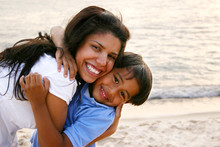

In [ ]:
img_name = 'img_test_2.jpg'
image = Image.open(img_name)
image

Extract the embeddings from original CLIP model

In [ ]:
# get visual embedding
inputs = processor(images=image, return_tensors="tf")
image_features = clip_model_tf.get_image_features(**inputs)
image_features = image_features.numpy()
image_features = np.squeeze(image_features)
image_features.shape

(512,)

We create a clip-style sentiment caption for every label from the taxonomy using the following structure "a photo that evokes $sentiment$". For example, "a photo that evokes cheerfullness"

In [ ]:
#get text embeddings
text_features = []

for sentiment in sentiment_labels:
  inputs = tokenizer(["a photo that evokes "+sentiment], padding=True, return_tensors="tf")
  text_feat_temp = clip_model_tf.get_text_features(**inputs)[0]
  text_features.append(text_feat_temp.numpy())

text_features = np.asarray(text_features)
text_features.shape

(25, 512)

Call our trained CLIP-E model 😊😍😭😀😒😡

In [ ]:
vision_encoder = create_vision_encoder()
text_encoder = create_text_encoder()
model = CLIP_E_contrastive(text_encoder, vision_encoder, temperature=1)
model.built = True
model.load_weights('clip-e_contrastive.hdf5')

**Inference**

In [ ]:
# build pairs of each sentiment text embedding with the same image embedding to match clip-e model input
x = get_pairs(text_features,image_features)

#inference:
text_output,img_output = model.predict(x, verbose=0)

img_output = img_output[0] #because all the image outputs correspond to the same image

y = similarity(img_output,text_output)

Sentiment Classification: contentment


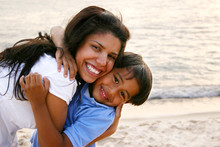

In [ ]:
print('Sentiment Classification:', sentiment_labels[y])
image

It's also interesting to see the top-k predictions

In [ ]:
k = 5
y_all_similarities = similarity_probs(img_output,text_output)
similarities_ordered = np.sort(y_all_similarities)[::-1]
similarities_ordered_index = np.argsort(y_all_similarities)[::-1]
sentiment_labels_np = np.asarray(sentiment_labels)
top_k_preds = sentiment_labels_np[similarities_ordered_index]

print('Top ', k, ' predictions')
for i in range(k):
  print(str(i+1)+':',top_k_preds[i])


Top  5  predictions
1: contentment
2: affection
3: cheerfullness
4: enthrallment
5: optimism


# 5. Testing other taxonomies

5.1 Parrot's model primary emotions (6 categories)

In [ ]:
sentiment_labels = ['anger', 'fear','joy', 'love', 'sadness', 'surprise']

text_features = []
for sentiment in sentiment_labels:
  inputs = tokenizer(["a photo that evokes "+sentiment], padding=True, return_tensors="tf")
  text_feat_temp = clip_model_tf.get_text_features(**inputs)[0]
  text_features.append(text_feat_temp.numpy())
text_features = np.asarray(text_features)

# build pairs
x = get_pairs(text_features,image_features)
#inference:
text_output,img_output = model.predict(x, verbose=0)
img_output = img_output[0] #because all the image outputs correspond to the same image
y = similarity(img_output,text_output)

print('Sentiment Classification between 6 categories:', sentiment_labels[y])

Sentiment Classification between 6 categories: love


5.2 We can also test using a binary taxonomy. However, for the binary case, we build the captions slightly different: "a photo that evokes a $sentiment$ feeling"

In [ ]:
binary_sentiment_labels = ['negative', 'positive']

text_features = []
for sentiment in binary_sentiment_labels:
  inputs = tokenizer(["a photo that evokes a "+ sentiment +" feeling"], padding=True, return_tensors="tf")
  text_feat_temp = clip_model_tf.get_text_features(**inputs)[0]
  text_features.append(text_feat_temp.numpy())
text_features = np.asarray(text_features)

# build pairs
x = get_pairs(text_features,image_features)
#inference:
text_output,img_output = model.predict(x, verbose=0)
img_output = img_output[0] #because all the image outputs correspond to the same image
y = similarity(img_output,text_output)

print('Sentiment Classification between binary categories:', binary_sentiment_labels[y])

Sentiment Classification between binary categories: positive


5.3 Last, testing using the Plutchik emotion wheel categories

Sentiment Classification between Plutchik categories: contentment


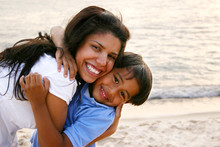

In [ ]:
sentiment_labels = ['amusement', 'anger','awe','contentment','disgust', 'excitement','fear','sadness']

text_features = []
for sentiment in sentiment_labels:
  inputs = tokenizer(["a photo that evokes "+sentiment], padding=True, return_tensors="tf")
  text_feat_temp = clip_model_tf.get_text_features(**inputs)[0]
  text_features.append(text_feat_temp.numpy())
text_features = np.asarray(text_features)

# build pairs
x = get_pairs(text_features,image_features)
#inference:
text_output,img_output = model.predict(x, verbose=0)
img_output = img_output[0] #because all the image outputs correspond to the same image
y = similarity(img_output,text_output)

print('Sentiment Classification between Plutchik categories:', sentiment_labels[y])
image